# Basic regression with ARIMA errors.

This notebook contains an implemenation of regression with ARIMA errors.

In this implementation months of the year and weeks of the year are represented by seasonal indexes (dummy variables either 0 or 1).

## Imports

In [1]:
import pandas as pd
import numpy as np

from forecast_tools.baseline import SNaive, Naive1
from forecast_tools.metrics import mean_absolute_error
from forecast_tools.datasets import load_emergency_dept

from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [2]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    data - arraylike - the training data
    preds - numpy.array, vector of predictions 
    
    Returns:
    -------
    pandas.DataFrame
    '''
    start = pd.date_range(start=data.index.max(), periods=2, 
                          freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

In [3]:
def plot_prediction_intervals(train, preds, intervals, 
                              test=None, show_train_size=None, figsize=(12,4)):
    '''
    Helper function to plot training data, point preds
    and 2 sets of prediction intevals
    
    assume 2 sets of PIs are provided!
    '''
    
    if show_train_size is None:
        show_train_size = len(train)
        
    train = train[-show_train_size:]
    ax = train.plot(figsize=figsize)
    

    mean = preds_as_series(train, preds)
    intervals_80 = preds_as_series(train, intervals[0])
    intervals_90 = preds_as_series(train, intervals[1])

    mean.plot(ax=ax, label='point forecast')

    ax.fill_between(intervals_80.index, mean[0], intervals_80[1], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,mean[0], intervals_80[0], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,intervals_80[1], intervals_90[1], 
                    alpha=0.2,
                    label='90% PI', color='purple');

    ax.fill_between(intervals_80.index,intervals_80[0], intervals_90[0], 
                    alpha=0.2,
                    label='90% PI', color='purple');
    
    if test is None:
        ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', 
                   '90%PI'], loc=2)
    else:
        test.plot(ax=ax, color='black', marker='o', ls='')
        ax.legend(['train', 'point forecast', 'Test', '80%PI', 
                   '_ignore','_ignore', '90%PI'], loc=2)

# Function to get seasonal indexes

In [85]:
def get_seasonal_indexes(idx, include_month=True, include_dow=True):
    '''
    Seasonal indexes for use with regression.
    
    Params:
    ------
    idx: pd.DataTimeIndex
        Dates inclued in the dataframe
        
    include_month: bool, optional (default=True)
        Include 11 dummy variables for month of year
        
    include_dow: bool. optional (default=False)
        Include 6 dummy variables for month of year
        
    Returns:
    --------
    pd.DataFrame
    
    '''
    seasonal_idx = pd.DataFrame()
    
    if include_month:
        # uses the pd.get_dummies function 
        seasonal_idx = pd.concat([seasonal_idx, pd.get_dummies(idx.month,  prefix='m', 
                                                               drop_first=True)], axis=1)
        
    if include_dow:
        seasonal_idx = pd.concat([seasonal_idx, pd.get_dummies(idx.weekday, prefix='dow', 
                                                               drop_first=True)], axis=1)
        
    # set the index
    seasonal_idx.index = idx
        
    return seasonal_idx

## Example with `forecast_tools` ED dataset

In [86]:
TARGET = 0.80
HOLDOUT = 28
PERIOD = 7

attends = load_emergency_dept()

# train-test split
train = attends[:-HOLDOUT]
test = attends[-HOLDOUT:]


X = get_seasonal_indexes(train.index)
# quick look at 
X.tail(7)

,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
date,,,,,,,,,,,,,,,,,
2017-11-27,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2017-11-28,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2017-11-29,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2017-11-30,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2017-12-01,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2017-12-02,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2017-12-03,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [28]:
model = auto_arima(train, exogenous=X, m=PERIOD, d=1, supress_warnings=True, maxiter=100)

In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  316
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 7)   Log Likelihood               -1311.687
Date:                           Wed, 26 Jan 2022   AIC                           2673.375
Time:                                   14:22:21   BIC                           2767.189
Sample:                               01-22-2017   HQIC                          2710.857
                                    - 12-03-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1338      0.250      0.535      0.593      -0.357       0.624
m_2           -5.0566      7.670     -0.659      0.510     -20.089       9.976
m_3            2.7863      8.920      0.312      0.755     -14.696      20.269
m_4            5.1733     11.993      0.431      0.666     -18.333      28.679
m_5            6.7298     15.268      0.441      0.659     -23.195      36.655
m_6            5.4998     19.280      0.285      0.775     -32.288      43.288
m_7           14.3630     22.904      0.627      0.531     -30.529      59.255
m_8            2.8622     26.413      0.108      0.914     -48.907      54.631
m_9            2.3683     30.859      0.077      0.939     -58.114      62.851
m_10          -5.3976     34.081     -0.158      0.874     -72.195      61.400
m_11          -8.4160     38.036     -0.221      0.825     -82.964      66.132
m_12          -6.3737     40.986     -0.156      0.876     -86.705      73.957
dow_1         -4.8595      2.405     -2.020      0.043      -9.574      -0.145
dow_2         29.8776      2.522     11.845      0.000      24.934      34.822
dow_3         43.4799      2.479     17.542      0.000      38.622      48.338
dow_4         27.5121      2.560     10.747      0.000      22.494      32.530
dow_5          7.7478      2.632      2.943      0.003       2.588      12.907
dow_6         -0.2055      2.713     -0.076      0.940      -5.522       5.111
ar.L1         -0.9838      0.084    -11.689      0.000      -1.149      -0.819
ar.L2          0.0138      0.066      0.209      0.835      -0.115       0.143
ma.L1      -2.714e-05      3.654  -7.43e-06      1.000      -7.162       7.162
ma.L2         -1.0000      0.095    -10.555      0.000      -1.186      -0.814
ma.S.L7       -0.1445      0.056     -2.602      0.009      -0.253      -0.036
ma.S.L14      -0.1935      0.068     -2.847      0.004      -0.327      -0.060
sigma2       243.4068      0.015   1.64e+04      0.000     243.378     243.436
===================================================================================
Ljung-Box (Q):                       40.97   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.43   Prob(JB):                         0.58
Heteroskedasticity (H):               0.99   Skew:                             0.04
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.44e+23. Standard errors may be unstable.
"""

In [97]:
def make_future_dataframe(h, y_train, include_mth=True, include_dow=True):
    '''
    Make a dataframe h steps into the future of y_train
    
    Params:
    ------
    h: int
        Forecast horizon
        
    y_train: pd.DataFrame
        Dataframe containing training data.  Must have a DataTimeIndex
    
    '''
    idx = pd.date_range(start=y_train.iloc[-1].name, periods=y_train.shape[0]+h, freq='D')
    seasonal_idxs = get_seasonal_indexes(idx, include_month=True, include_dow=True)
    return seasonal_idxs.iloc[-h:]


In [98]:
future_dataframe = make_future_dataframe(HOLDOUT, train)
future_dataframe.head()

,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
2018-10-15,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2018-10-16,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2018-10-17,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2018-10-18,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2018-10-19,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [99]:
def forecast(model, future_dataframe, return_predict_int=True, alpha=0.05):
    '''
    Forecast with regression with ARIMA errors
    
    Params:
    ------
    h: int
        Forecast horizon
        
    future_dataframe: pd.DataFrame
        Future dataframe containing datetimeindex + seasonal indexes
    
    return_predict_int: bool, optional (default=True)
        Prediction interval with predictions
        
    alpha: float, optional (Deault=0.05)
        1 - coverage for prediction interval
        
    Returns:
    --------
    preds, intervals
    '''
    
    h = future_dataframe.shape[0]
    return model.predict(n_periods=h, exogenous=future_dataframe, 
                         return_conf_int=return_predict_int, 
                         alpha=alpha)

In [102]:
preds, intervals_95 = forecast(model, future_dataframe, alpha=0.05)
preds, intervals_80 = forecast(model, future_dataframe, alpha=0.2)
intervals = np.array([intervals_80, intervals_95])

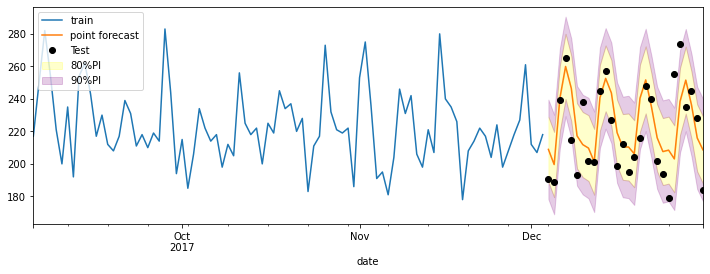

In [105]:
plot_prediction_intervals(train, preds, intervals, test=test, 
                          show_train_size=90)